### Import the dependencies

In [295]:
%load_ext lab_black

# Common Imports
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA

# Assessing performance
from sklearn.model_selection import GridSearchCV

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Making a prediction with the direct multioutput regression model
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

# To make this notebook's output identical at every run
np.random.seed(42)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


### Load the data

In [296]:
data = (
    pd.read_csv("position_log_v2.csv")
    .query("marker != 8")  # too many null values for tag 1
    .query("marker % 2 == 0")
    .drop(["z", "anchors"], axis=1)
    .reset_index(drop=True)
)

data["tag"] = data["tag"].replace(52630, 3)

data["marker"] = data["marker"].map(
    {j: i + 1 for i, j in enumerate(data.marker.unique())}
)

data.columns = [
    "position",
    "time",
    "tag",
    "x",
    "y",
    "anchor_1",
    "anchor_2",
    "anchor_3",
    "anchor_4",
    "anchor_5",
]

data

,position,time,tag,x,y,anchor_1,anchor_2,anchor_3,anchor_4,anchor_5
0,1,42:24.3,1,1595,1916,204.0,871.0,1072.0,375.0,820.0
1,1,42:24.3,2,1614,1989,209.0,871.0,1082.0,468.0,820.0
2,1,42:24.3,3,1620,1971,189.0,882.0,1117.0,401.0,817.0
3,1,42:24.4,1,1595,1915,205.0,872.0,1072.0,375.0,824.0
4,1,42:24.4,2,1614,1988,214.0,875.0,1082.0,401.0,827.0
...,...,...,...,...,...,...,...,...,...,...
27655,11,11:29.9,2,1315,1863,336.0,602.0,814.0,160.0,603.0
27656,11,11:29.9,3,1345,1886,327.0,636.0,837.0,240.0,615.0
27657,11,11:30.0,1,1313,1899,332.0,618.0,801.0,184.0,586.0
27658,11,11:30.0,2,1315,1861,338.0,603.0,812.0,159.0,599.0


### Visualize the noise

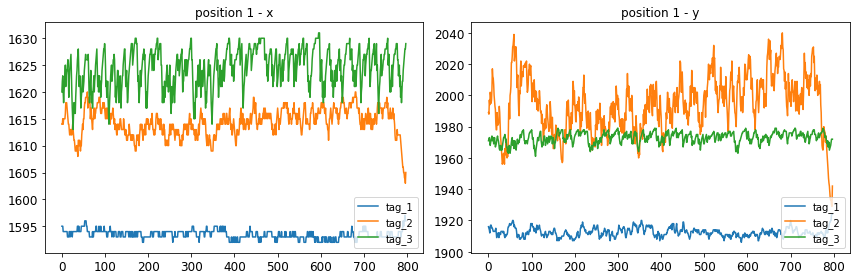

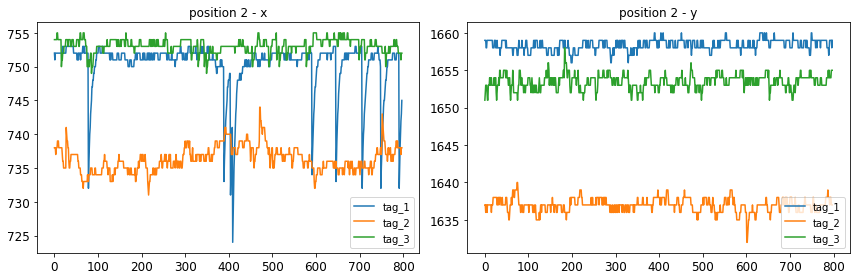

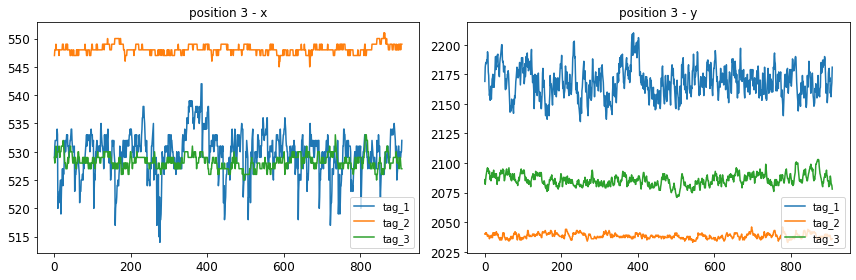

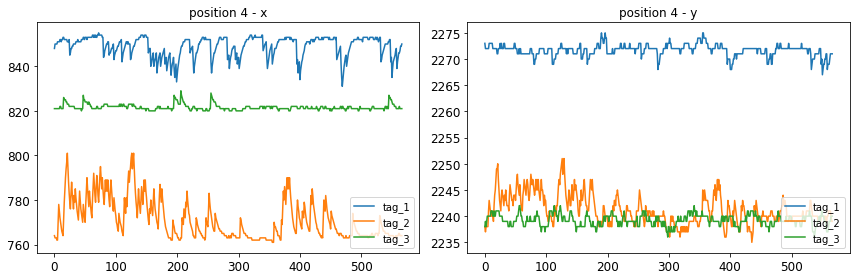

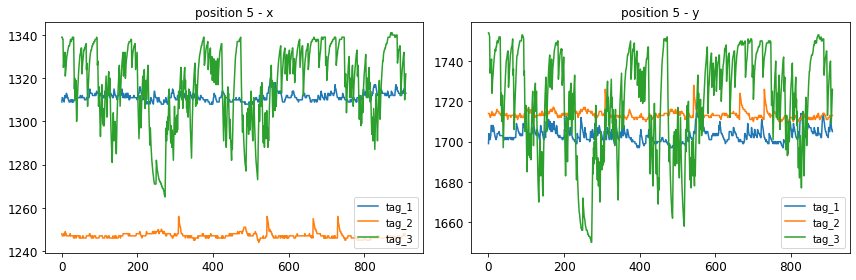

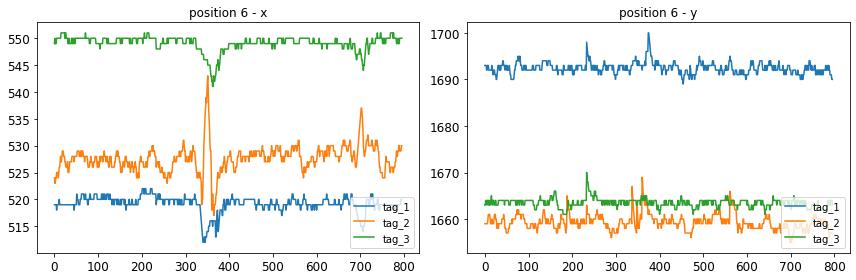

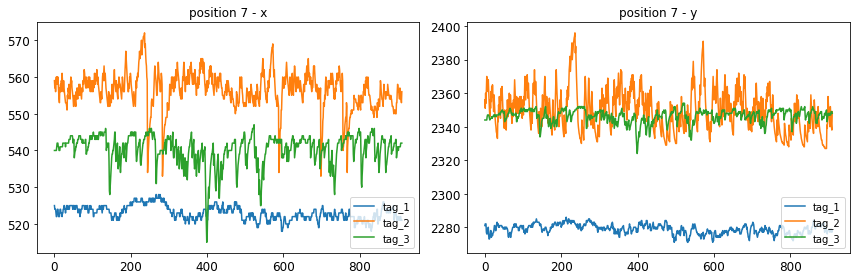

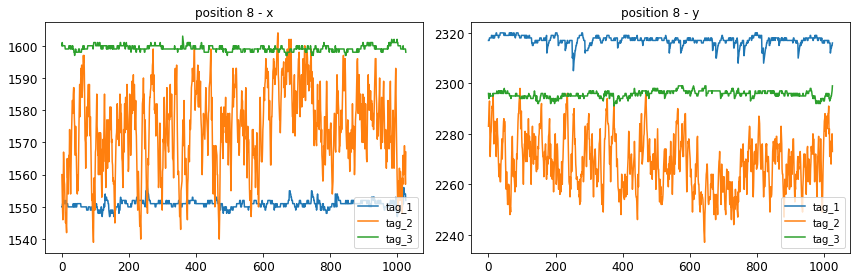

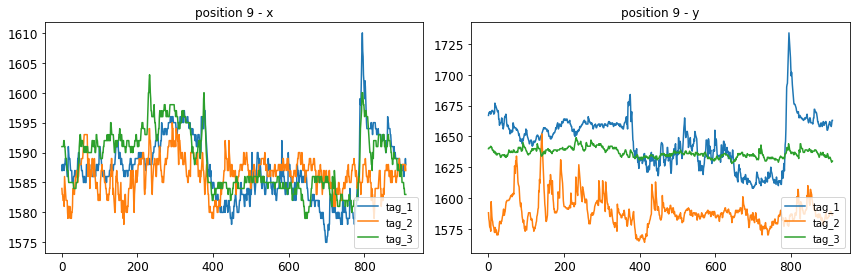

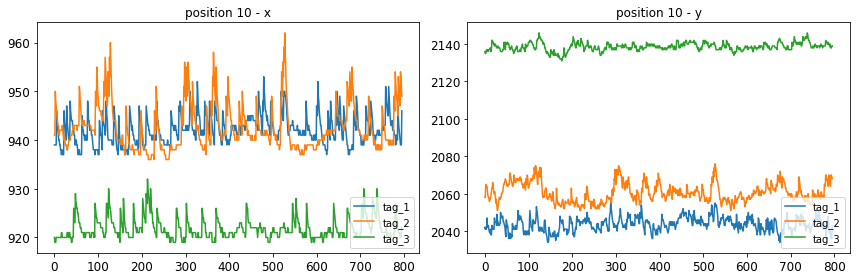

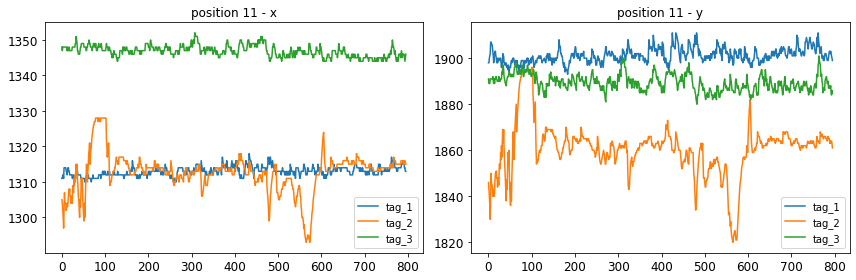

In [297]:
for i in data["position"].unique():
    tag_1_x = data.query(f"position == {i} & tag == 1").x.reset_index(drop=True)
    tag_2_x = data.query(f"position == {i} & tag == 2").x.reset_index(drop=True)
    tag_3_x = data.query(f"position == {i} & tag == 3").x.reset_index(drop=True)

    tag_1_y = data.query(f"position == {i} & tag == 1").y.reset_index(drop=True)
    tag_2_y = data.query(f"position == {i} & tag == 2").y.reset_index(drop=True)
    tag_3_y = data.query(f"position == {i} & tag == 3").y.reset_index(drop=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(tag_1_x, label="tag_1")
    axes[0].plot(tag_2_x, label="tag_2")
    axes[0].plot(tag_3_x, label="tag_3")
    axes[0].legend(loc="lower right")
    axes[0].title.set_text(f"position {i} - x")

    axes[1].plot(tag_1_y, label="tag_1")
    axes[1].plot(tag_2_y, label="tag_2")
    axes[1].plot(tag_3_y, label="tag_3")
    axes[1].legend(loc="lower right")
    axes[1].title.set_text(f"position {i} - y")

    fig.tight_layout()
    fig.show()

### Plot the histogram and the PDF for each position

#### x coordinates

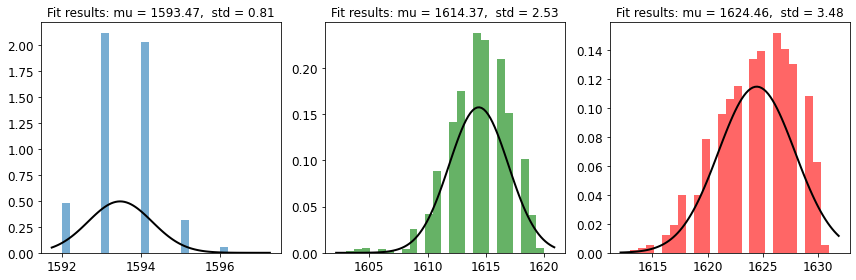

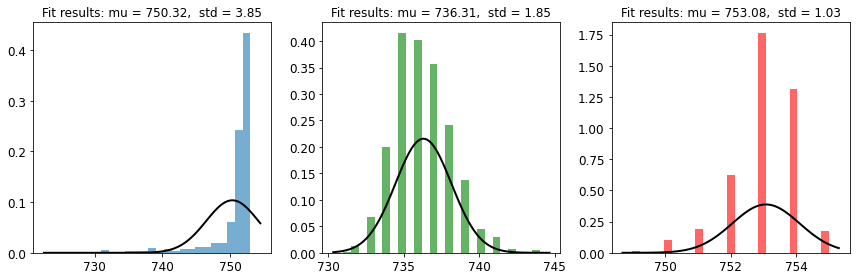

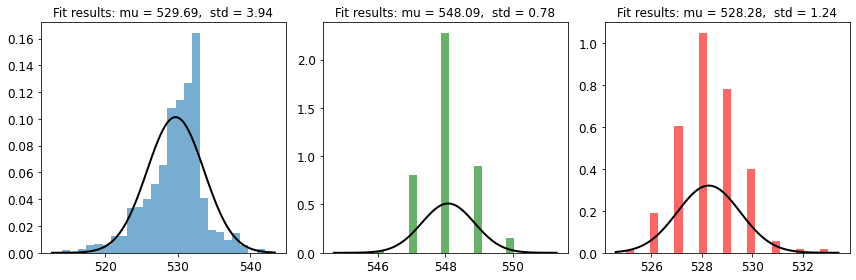

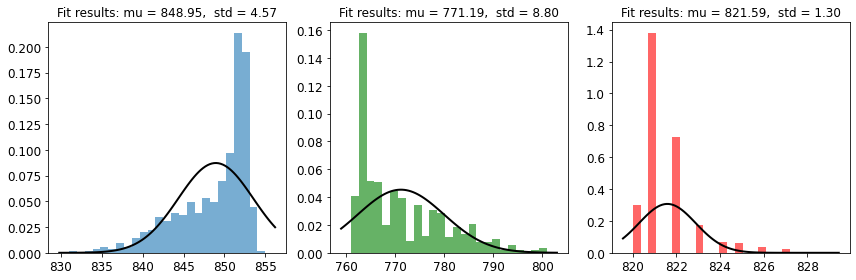

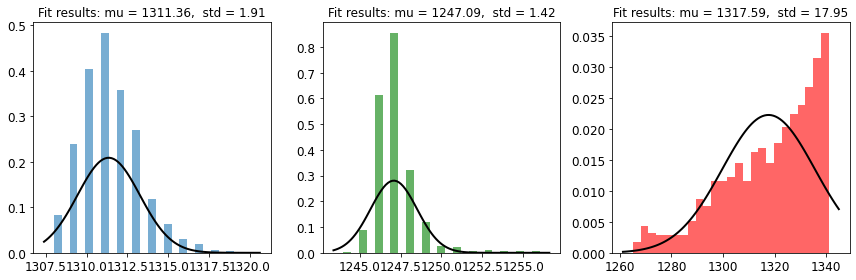

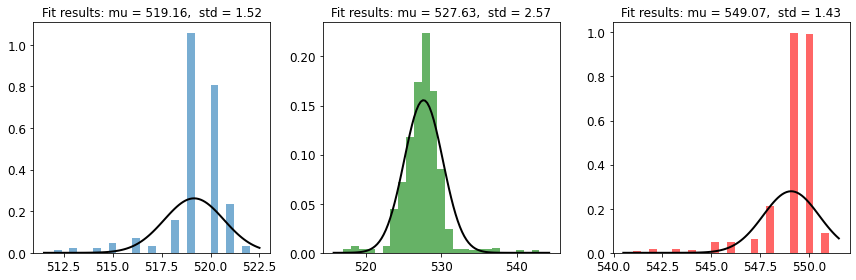

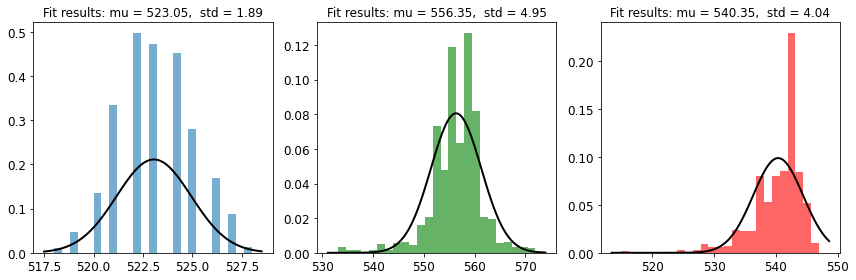

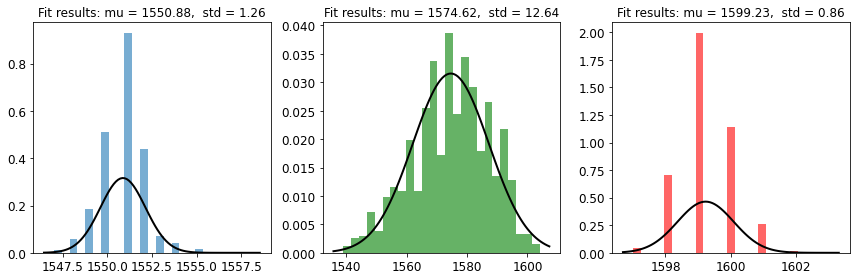

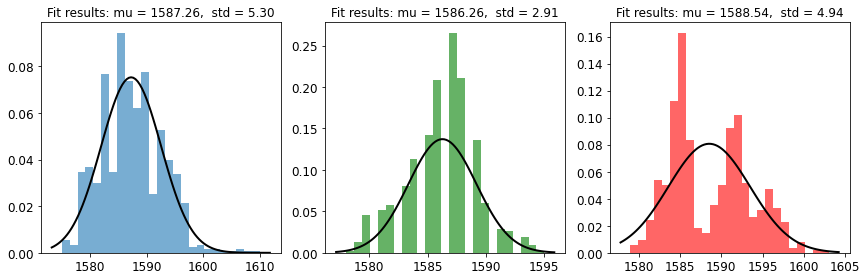

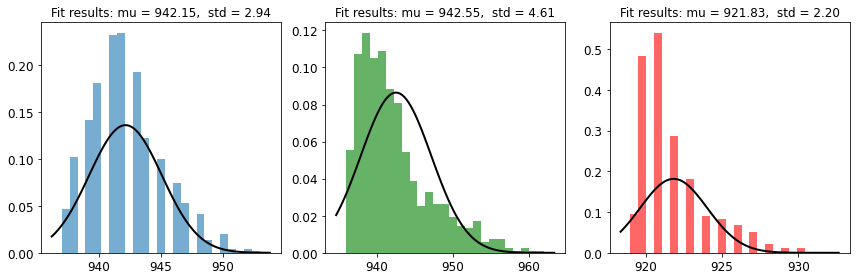

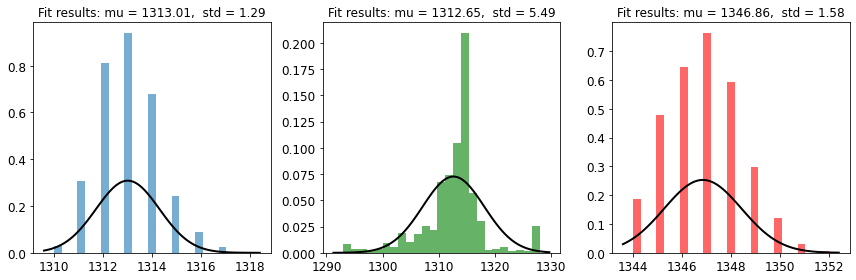

In [376]:
for i in sorted(data["position"].unique()):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    tag_1 = data.query(f"position == {i} & tag == 1").x
    tag_2 = data.query(f"position == {i} & tag == 2").x
    tag_3 = data.query(f"position == {i} & tag == 3").x

    # Fit a normal distribution to the data:
    mu_1, std_1 = norm.fit(tag_1)
    mu_2, std_2 = norm.fit(tag_2)
    mu_3, std_3 = norm.fit(tag_3)

    # Plot the histogram.
    axes[0].hist(tag_1, bins=25, density=True, alpha=0.6)
    axes[1].hist(tag_2, bins=25, density=True, alpha=0.6, color="g")
    axes[2].hist(tag_3, bins=25, density=True, alpha=0.6, color="r")

    # Plot the PDF.
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_1, std_1)
    axes[0].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_1, std_1)
    axes[0].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_2, std_2)
    axes[1].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_2, std_2)
    axes[1].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_3, std_3)
    axes[2].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_3, std_3)
    axes[2].title.set_text(title)

    fig.tight_layout()
    fig.show()

    fig.savefig(f"graphs/pos_{i}_x.png", bbox_inches="tight")

#### y coordinates

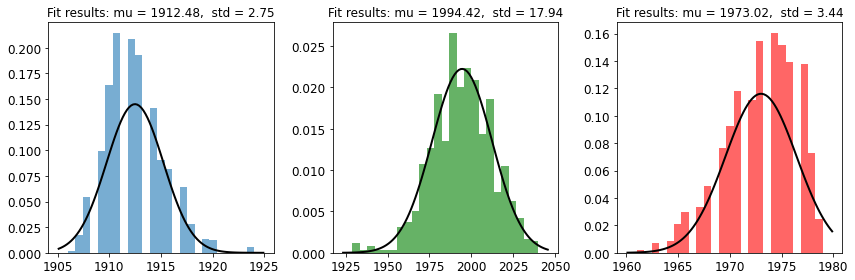

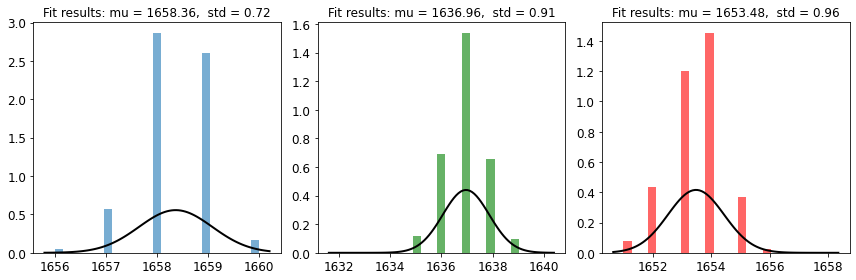

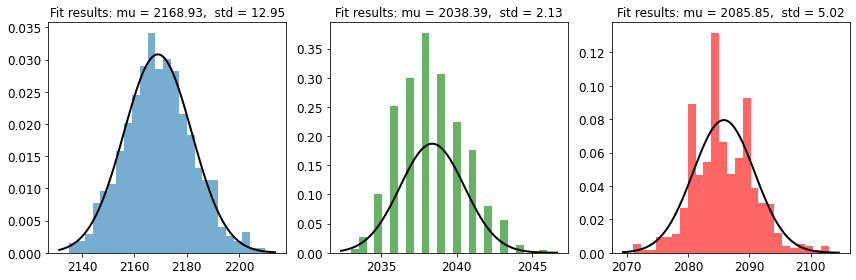

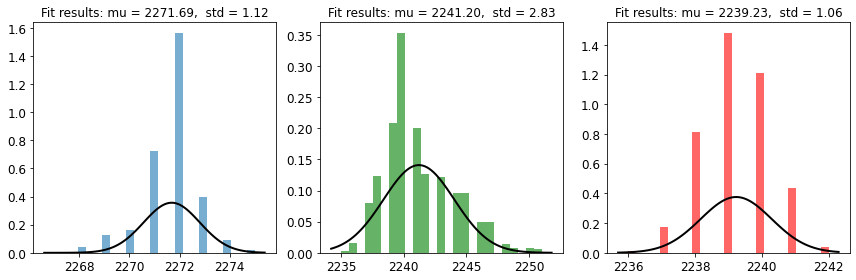

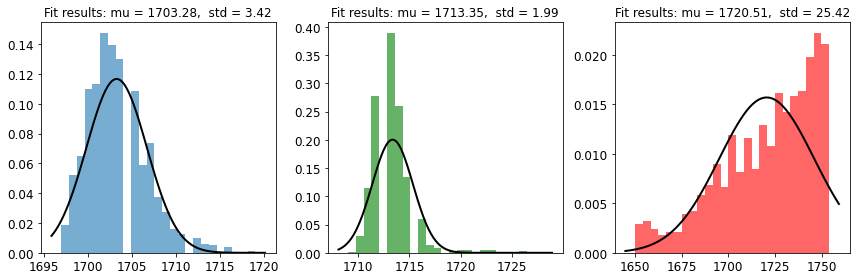

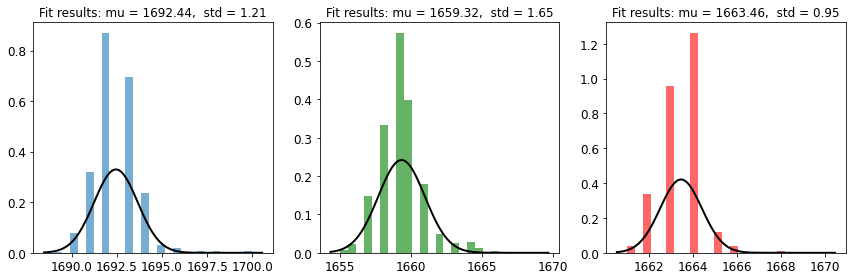

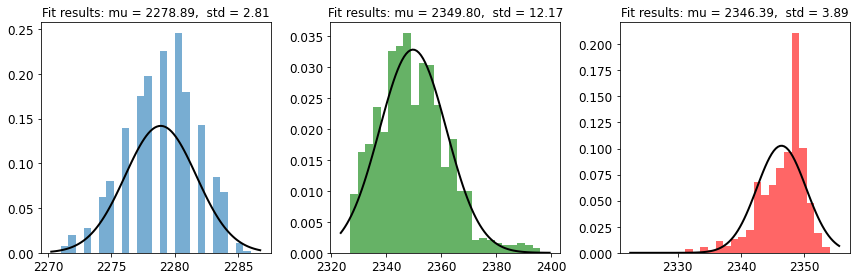

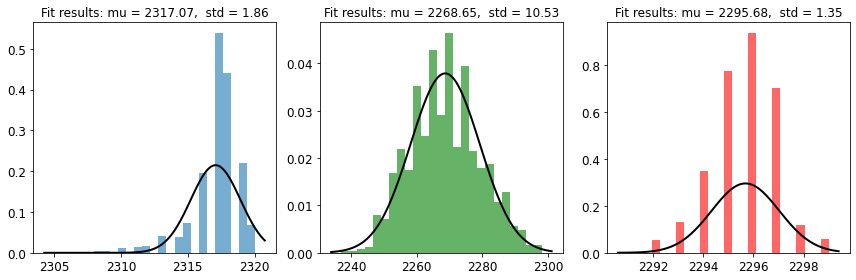

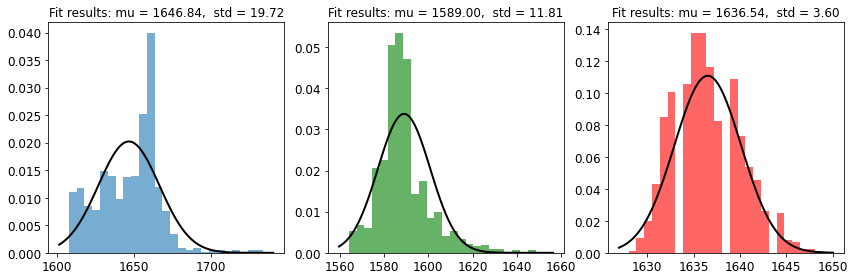

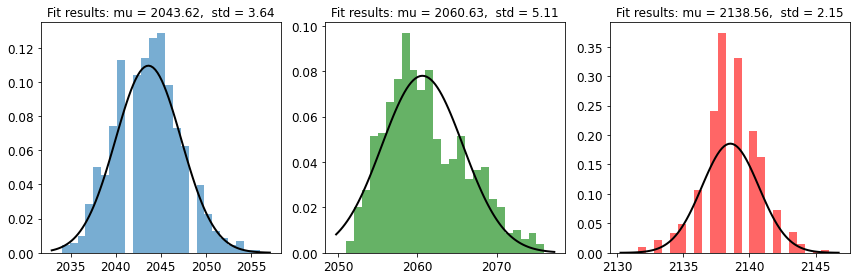

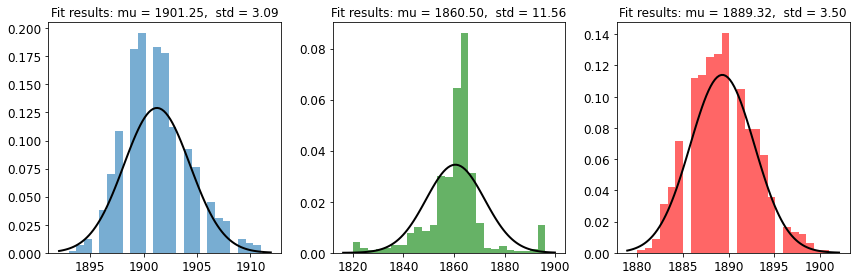

In [377]:
for i in sorted(data["position"].unique()):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    tag_1 = data.query(f"position == {i} & tag == 1").y
    tag_2 = data.query(f"position == {i} & tag == 2").y
    tag_3 = data.query(f"position == {i} & tag == 3").y

    # Fit a normal distribution to the data:
    mu_1, std_1 = norm.fit(tag_1)
    mu_2, std_2 = norm.fit(tag_2)
    mu_3, std_3 = norm.fit(tag_3)

    # Plot the histogram.
    axes[0].hist(tag_1, bins=25, density=True, alpha=0.6)
    axes[1].hist(tag_2, bins=25, density=True, alpha=0.6, color="g")
    axes[2].hist(tag_3, bins=25, density=True, alpha=0.6, color="r")

    # Plot the PDF.
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_1, std_1)
    axes[0].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_1, std_1)
    axes[0].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_2, std_2)
    axes[1].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_2, std_2)
    axes[1].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_3, std_3)
    axes[2].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_3, std_3)
    axes[2].title.set_text(title)

    fig.tight_layout()
    fig.show()

    fig.savefig(f"graphs/pos_{i}_y.png", bbox_inches="tight")

In [406]:
x_pos = [1597, 766, 530, 839, 1269, 530, 1597, 530, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 1690, 2302, 2302, 2083, 1925]
true_pos = zip(x_pos, y_pos)

for i in sorted(data["position"].unique()):
    tag_1 = data.query(f"position == {i} & tag == 1")
    tag_2 = data.query(f"position == {i} & tag == 2")
    tag_3 = data.query(f"position == {i} & tag == 3")

    x_avg = int((tag_1.x.mean() + tag_2.x.mean() + tag_3.x.mean()) / 3)
    y_avg = int((tag_1.y.mean() + tag_2.y.mean() + tag_3.y.mean()) / 3)

    print("Calc:  ", (x_avg, y_avg))
    print("Actual:", next(true_pos))
    print()

Calc:   (1610, 1959)
Actual: (1597, 1958)

Calc:   (746, 1649)
Actual: (766, 1690)

Calc:   (535, 2097)
Actual: (530, 2040)

Calc:   (813, 2250)
Actual: (839, 2244)

Calc:   (1292, 1712)
Actual: (1269, 1744)

Calc:   (531, 1671)
Actual: (530, 1690)

Calc:   (539, 2325)
Actual: (1597, 1690)

Calc:   (1574, 2293)
Actual: (530, 2302)

Calc:   (1587, 1624)
Actual: (1597, 2302)

Calc:   (935, 2080)
Actual: (944, 2083)

Calc:   (1324, 1883)
Actual: (1315, 1925)



[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 798
    # variables        = 3
    chi-square         = 30.5494840
    reduced chi-square = 0.03842702
    Akaike info crit   = -2597.68312
    Bayesian info crit = -2583.63679
##  Warning: uncertainties could not be estimated:
    amp:  at initial value
    cen:  at initial value
    wid:  at initial value
[[Variables]]
    amp:  5.00000000 (init = 5)
    cen:  5.00000000 (init = 5)
    wid:  1.00000000 (init = 1)


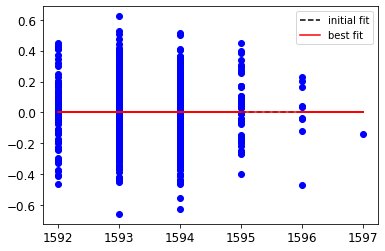

In [348]:
import matplotlib.pyplot as plt
from numpy import exp, pi, sqrt
from lmfit import Model

x = data.query(f"position == 1 & tag == 1").x.reset_index(drop=True)
y = gaussian(x, 8, -1, 3) + random.normal(0, 0.2, x.size)


def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2 * pi) * wid)) * exp(-((x - cen) ** 2) / (2 * wid ** 2))


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=5, cen=5, wid=1)

print(result.fit_report())

plt.plot(x, y, "bo")
plt.plot(x, result.init_fit, "k--", label="initial fit")
plt.plot(x, result.best_fit, "r-", label="best fit")
plt.legend(loc="best")
plt.show()

In [329]:
from scipy.optimize import curve_fit

# Function to calculate the Gaussian with constants a, b, and c
def gaussian(x, a, b, c):
    return a * np.exp(-np.power(x - b, 2) / (2 * np.power(c, 2)))



x_dummy = data.query(f"position == 1 & tag == 1").x.reset_index(drop=True)
y_dummy = gaussian(x_dummy, 8, -1, 3)

# Fit the dummy Gaussian data
pars, cov = curve_fit(
    f=gaussian, xdata=x_dummy, ydata=y_dummy, p0=[0, 0, 0], bounds=(-np.inf, np.inf)
)
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))
# Calculate the residuals
res = y_dummy - gaussian(x_dummy, *pars)

In [330]:
y_dummy

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
793    0.0
794    0.0
795    0.0
796    0.0
797    0.0
Name: x, Length: 798, dtype: float64

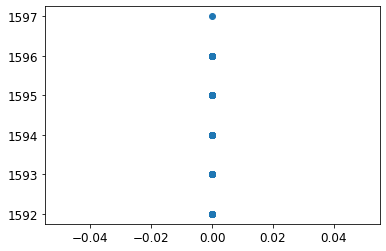

In [328]:
ax = plt.gca()
ax.scatter(x_dummy, res)

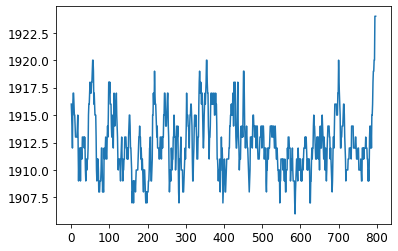

In [322]:
plt.plot(res)

### Noise at each position

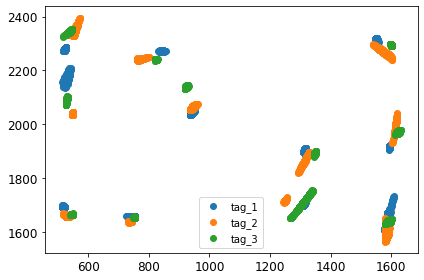

In [214]:
ax = plt.gca()
ax.scatter(data.query("tag == 1").x, data.query("tag == 1").y, label="tag_1")
ax.scatter(data.query("tag == 2").x, data.query("tag == 2").y, label="tag_2")
ax.scatter(data.query("tag == 3").x, data.query("tag == 3").y, label="tag_3")

plt.legend(loc="best")
plt.tight_layout()
plt.show()

### For a given reading, compute the distance from tag 1 to tag 2, tag 2 to tag 3, and tag 1 to tag 3

$d(tag_1,tag_2) = \sqrt{(tag_{2_x} - tag_{1_x})^2 + (tag_{2_y} - tag_{1_y})^2}$

$d(tag_2,tag_3) = \sqrt{(tag_{3_x} - tag_{2_x})^2 + (tag_{3_y} - tag_{2_y})^2}$

$d(tag_1,tag_3) = \sqrt{(tag_{3_x} - tag_{1_x})^2 + (tag_{3_y} - tag_{1_y})^2}$

In [215]:
data_tag_1 = data.query("tag == 1").loc[:, ["x", "y"]].copy().reset_index(drop=True)
data_tag_2 = data.query("tag == 2").loc[:, ["x", "y"]].copy().reset_index(drop=True)
data_tag_3 = data.query("tag == 3").loc[:, ["x", "y"]].copy().reset_index(drop=True)

In [216]:
AB = data_tag_1.sub(data_tag_2).pow(2).sum(axis=1).pow(0.5)
BC = data_tag_2.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)
AC = data_tag_1.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)

distances = pd.DataFrame(
    data=[AB, BC, AC], index=["tag_1_to_tag_2", "tag_2_to_tag_3", "tag_1_to_tag_3"]
).T

distances

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
0,75.432089,18.973666,60.415230
1,75.432089,17.888544,63.071388
2,85.375641,25.298221,65.306967
3,84.403791,23.769729,64.474801
4,88.526832,34.132096,57.271284
...,...,...,...
9215,40.000000,39.824616,34.438351
9216,38.052595,35.805028,35.355339
9217,37.054015,34.409301,34.481879
9218,37.054015,37.802116,34.928498


### Drop rows based on standard deviation

In [255]:
true_mean = 21.59
calc_mean_distances = distances.to_numpy().mean()
std_distances = distances.to_numpy().std()

In [256]:
calc_mean_distances, std_distances

(51.965722316201536, 28.96962034612344)

In [169]:
lower_bnd = true_mean - std_distances if lower_bnd > 0 else 0
upper_bnd = true_mean + std_distances

lower_bnd, upper_bnd

(0, 50.55962034612344)

### Four Cases
1. All three are constrained by the bound - keep all (best case)
2. Only two are constrained by the bound
3. Only one is constrained by the bound
4. None of them are constrained by the bound - drop all (worst case)

In [289]:
bounded = (distances >= lower_bnd) & (distances <= upper_bnd)

bounded_all_three = bounded[(bounded.sum(axis=1) == 3)]
bounded_only_two = bounded[(bounded.sum(axis=1) == 2)]
bounded_only_one = ~bounded[(bounded.sum(axis=1) == 1)]
bounded_none = bounded[(bounded.sum(axis=1) == 0)]

In [290]:
bounded_all_three

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
798,True,True,True
799,True,True,True
800,True,True,True
801,True,True,True
802,True,True,True
...,...,...,...
9215,True,True,True
9216,True,True,True
9217,True,True,True
9218,True,True,True


In [291]:
bounded_only_two

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
31,True,True,False
32,True,True,False
33,True,True,False
36,True,True,False
37,True,True,False
...,...,...,...
8958,False,True,True
8959,False,True,True
8974,True,False,True
9009,True,False,True


In [292]:
bounded_only_one

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
0,True,False,True
1,True,False,True
2,True,False,True
3,True,False,True
4,True,False,True
...,...,...,...
9004,True,True,False
9005,True,True,False
9006,True,True,False
9007,True,True,False


In [293]:
bounded_none

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
53,False,False,False
55,False,False,False
56,False,False,False
57,False,False,False
58,False,False,False
...,...,...,...
7518,False,False,False
7519,False,False,False
7520,False,False,False
7521,False,False,False


In [91]:
data_tag_1.loc[bounded.index, ["x", "y"]]

,x,y
31,1594,1913
32,1594,1913
33,1594,1913
36,1595,1912
37,1595,1910
...,...,...
9215,1315,1903
9216,1314,1902
9217,1314,1901
9218,1313,1900


In [100]:
data_tag_2.loc[bounded.index, ["x", "y"]]

,x,y
31,1609,1961
32,1609,1956
33,1609,1957
36,1609,1959
37,1608,1956
...,...,...
9215,1315,1863
9216,1316,1864
9217,1316,1864
9218,1315,1863


### Drop row with the highest distance

In [217]:
data

,position,time,tag,x,y,anchor_1,anchor_2,anchor_3,anchor_4,anchor_5
0,1,42:24.3,1,1595,1916,204.0,871.0,1072.0,375.0,820.0
1,1,42:24.3,2,1614,1989,209.0,871.0,1082.0,468.0,820.0
2,1,42:24.3,3,1620,1971,189.0,882.0,1117.0,401.0,817.0
3,1,42:24.4,1,1595,1915,205.0,872.0,1072.0,375.0,824.0
4,1,42:24.4,2,1614,1988,214.0,875.0,1082.0,401.0,827.0
...,...,...,...,...,...,...,...,...,...,...
27655,11,11:29.9,2,1315,1863,336.0,602.0,814.0,160.0,603.0
27656,11,11:29.9,3,1345,1886,327.0,636.0,837.0,240.0,615.0
27657,11,11:30.0,1,1313,1899,332.0,618.0,801.0,184.0,586.0
27658,11,11:30.0,2,1315,1861,338.0,603.0,812.0,159.0,599.0


In [218]:
highest_distance = distances.idxmax(axis=1).map(
    {"tag_1_to_tag_2": 1, "tag_2_to_tag_3": 2, "tag_1_to_tag_3": 3}
)
highest_distance

0       1
1       1
2       1
3       1
4       1
       ..
9215    1
9216    1
9217    1
9218    2
9219    2
Length: 9220, dtype: int64

In [223]:
for (indx1, row1), (indx2, row2), (indx3, row3) in zip(
    data[:-2].iterrows(), data[1:-1].iterrows(), data[2:].iterrows()
):

    err_tag = highest_distance.iloc[indx1 // 3]

    x_1, y_1 = row1["x"], row1["y"]
    x_2, y_2 = row2["x"], row2["y"]
    x_3, y_3 = row3["x"], row3["y"]

    if err_tag == 1:
        x_avg = (x_2 + x_3) // 2
        y_avg = (y_2 + y_3) // 2

        data.loc[indx1, "x"] = x_avg
        data.loc[indx1, "y"] = y_avg

    elif err_tag == 2:
        x_avg = (x_1 + x_3) // 2
        y_avg = (y_1 + y_3) // 2

        data.loc[indx2, "x"] = x_avg
        data.loc[indx2, "y"] = y_avg

    else:
        x_avg = (x_1 + x_2) // 2
        y_avg = (y_1 + y_2) // 2

        data.loc[indx3, "x"] = x_avg
        data.loc[indx3, "y"] = y_avg

In [224]:
data

,position,time,tag,x,y,anchor_1,anchor_2,anchor_3,anchor_4,anchor_5
0,1,42:24.3,1,1617,1980,204.0,871.0,1072.0,375.0,820.0
1,1,42:24.3,2,1607,1943,209.0,871.0,1082.0,468.0,820.0
2,1,42:24.3,3,1604,1951,189.0,882.0,1117.0,401.0,817.0
3,1,42:24.4,1,1618,1980,205.0,872.0,1072.0,375.0,824.0
4,1,42:24.4,2,1608,1943,214.0,875.0,1082.0,401.0,827.0
...,...,...,...,...,...,...,...,...,...,...
27655,11,11:29.9,2,1329,1893,336.0,602.0,814.0,160.0,603.0
27656,11,11:29.9,3,1314,1881,327.0,636.0,837.0,240.0,615.0
27657,11,11:30.0,1,1330,1873,332.0,618.0,801.0,184.0,586.0
27658,11,11:30.0,2,1329,1892,338.0,603.0,812.0,159.0,599.0


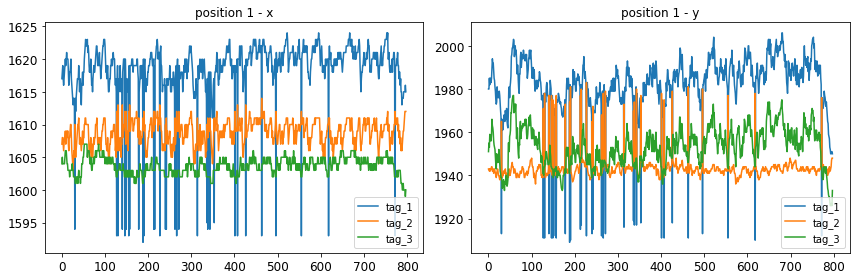

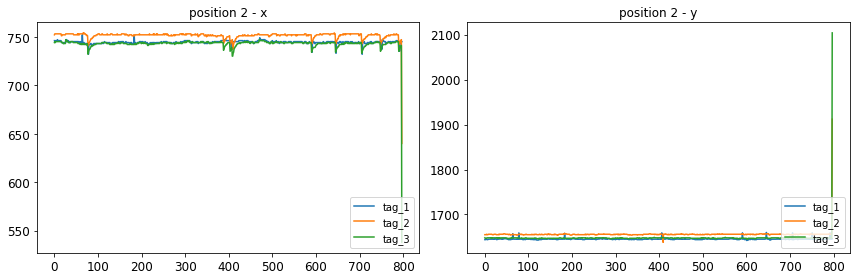

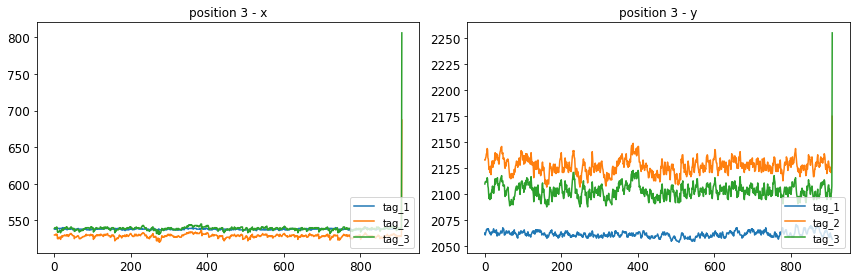

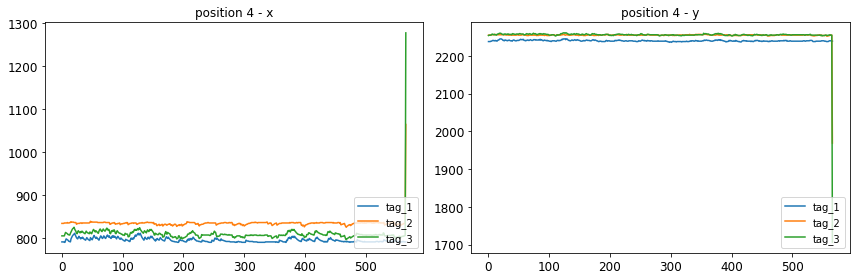

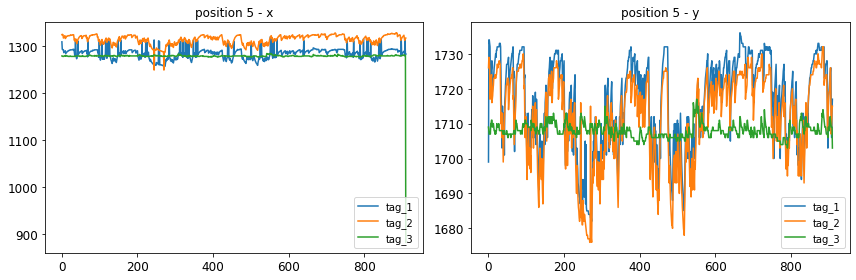

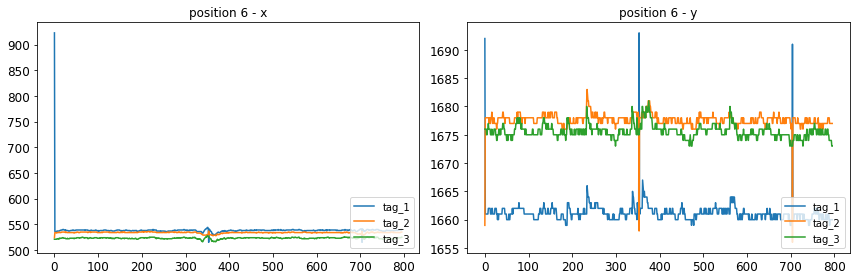

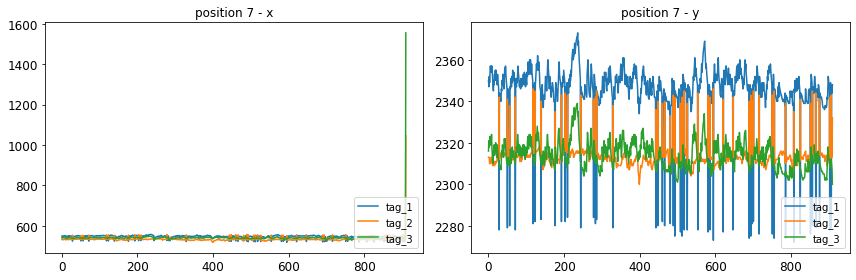

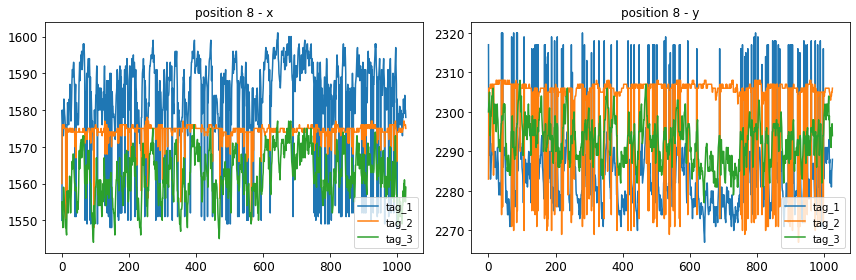

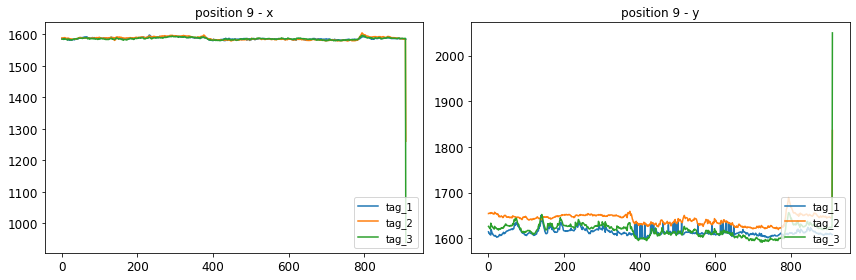

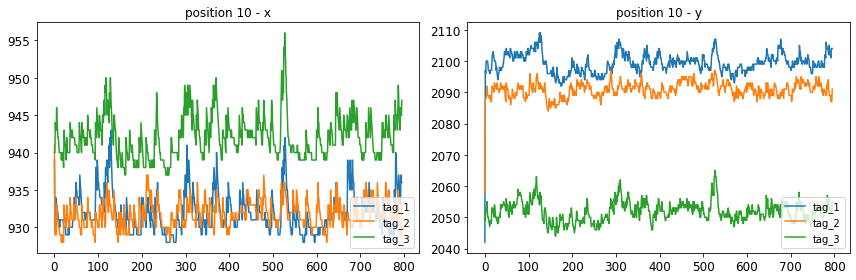

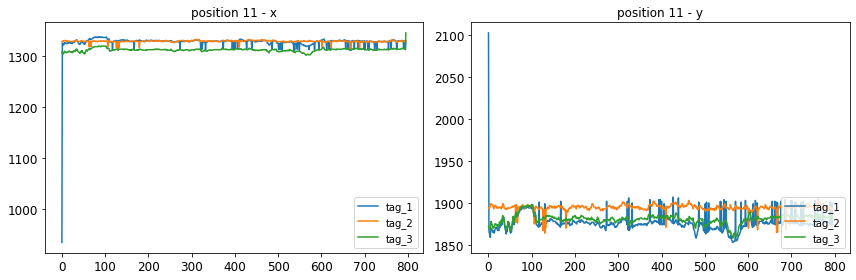

In [225]:
for i in data["position"].unique():
    tag_1_x = data.query(f"position == {i} & tag == 1").x.reset_index(drop=True)
    tag_2_x = data.query(f"position == {i} & tag == 2").x.reset_index(drop=True)
    tag_3_x = data.query(f"position == {i} & tag == 3").x.reset_index(drop=True)

    tag_1_y = data.query(f"position == {i} & tag == 1").y.reset_index(drop=True)
    tag_2_y = data.query(f"position == {i} & tag == 2").y.reset_index(drop=True)
    tag_3_y = data.query(f"position == {i} & tag == 3").y.reset_index(drop=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(tag_1_x, label="tag_1")
    axes[0].plot(tag_2_x, label="tag_2")
    axes[0].plot(tag_3_x, label="tag_3")
    axes[0].legend(loc="lower right")
    axes[0].title.set_text(f"position {i} - x")

    axes[1].plot(tag_1_y, label="tag_1")
    axes[1].plot(tag_2_y, label="tag_2")
    axes[1].plot(tag_3_y, label="tag_3")
    axes[1].legend(loc="lower right")
    axes[1].title.set_text(f"position {i} - y")

    fig.tight_layout()
    fig.show()

In [233]:
x_pos = [1597, 766, 530, 839, 1269, 530, 1597, 530, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 1690, 2302, 2302, 2083, 1925]

data["position"].map(dict(enumerate(x_pos, 1)))

0        1597
1        1597
2        1597
3        1597
4        1597
         ... 
27655    1315
27656    1315
27657    1315
27658    1315
27659    1315
Name: position, Length: 27660, dtype: int64

### Preprocess the data

In [ ]:
data = (
    pd.read_csv("position_log_v2.csv")
    .query("marker != 8")  # too many null values for tag 1
    .query("marker % 2 == 0")
    .drop(["x", "y", "z", "anchors", "time"], axis=1)
    .reset_index(drop=True)
)

data["tag"] = data["tag"].replace(52630, 3)

data["marker"] = data["marker"].map(
    {j: i + 1 for i, j in enumerate(data.marker.unique())}
)

data.columns = [
    "position",
    "tag",
    "anchor_1",
    "anchor_2",
    "anchor_3",
    "anchor_4",
    "anchor_5",
]

data

In [ ]:
position = data.query("tag == 1").loc[:, ["position"]].reset_index(drop=True)

data_tag_1 = (
    data.query("tag == 1")
    .drop(["position", "tag"], axis=1)
    .reset_index(drop=True)
    .fillna(0)
)

data_tag_2 = (
    data.query("tag == 2")
    .drop(["position", "tag"], axis=1)
    .reset_index(drop=True)
    .fillna(0)
)

data_tag_3 = (
    data.query("tag == 3")
    .drop(["position", "tag"], axis=1)
    .reset_index(drop=True)
    .fillna(0)
)

### Compute distance from A to B, B to C, and A to C

$d(A,B) = \sqrt{(A_1-B_1)^2 + (A_2-B_2)^2 + \dots + (A_n-B_n)^2}$

In [ ]:
data_tag_1

In [ ]:
AB = data_tag_1.sub(data_tag_2).pow(2).sum(axis=1).pow(0.5)
BC = data_tag_2.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)
AC = data_tag_1.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)

pd.DataFrame(data=[AB, BC, AC], index=["AB", "BC", "AC"]).T

In [ ]:
np.abs(AB - BC)

In [ ]:
np.abs(AB - AC)

In [ ]:
np.abs(AC - BC)

### Join the data

In [ ]:
data_tag_1.columns = map("{}_tag_1".format, data_tag_1.columns)
data_tag_2.columns = map("{}_tag_2".format, data_tag_2.columns)
data_tag_3.columns = map("{}_tag_3".format, data_tag_3.columns)

data = position.join([data_tag_1, data_tag_2, data_tag_3])
data

In [ ]:
data.isnull().sum()

In [ ]:
# Amount of readings per location
data["position"].value_counts()

### LOOCV for Evaluating Machine Learning Algorithms

In [ ]:
X_tx_pos = [1597, 766, 530, 839, 1269, 530, 1597, 530, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 1690, 2302, 2302, 2083, 1925]

for i in sorted(data["position"].astype(int).unique()):

    #####################################################################
    # X_train - train on 11/12
    #####################################################################

    # leave one position out
    training_data = data.query(f"position != {i}").reset_index(drop=True)
    position = training_data[["position"]].copy()
    X_train = training_data.drop("position", axis=1)

    # normalize the 10 positions
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(X_train)
    scaled_train_features = min_max_scaler.transform(X_train)

    # convert the normalized matrix to a dataframe
    X_train = pd.DataFrame(
        scaled_train_features, index=X_train.index, columns=X_train.columns
    )

    # add the position each row corresponds to
    X_train = position.join(X_train)

    X_train_transposed = pd.DataFrame()

    for j in X_train["position"].unique():

        # impute the null rows with the mean (fill 0 where this is not possible)
        X_train.loc[X_train["position"] == j] = (
            X_train.query(f"position == {j}")
            .fillna(X_train.query(f"position == {j}").mean())
            .fillna(0)
        )

        # stack the position data into a single row
        df = (
            X_train.query(f"position == {j}")
            .copy(deep=True)
            .drop("position", axis=1)
            .reset_index(drop=True)
        )

        df.index = df.index + 1
        df_out = df.stack()
        df_out.index = df_out.index.map("{0[1]}_{0[0]}".format)
        df_out = df_out.to_frame().T

        # compose everything in a single dateframe
        X_train_transposed = (
            X_train_transposed.append(df_out).fillna(0).reset_index(drop=True)
        )

    # match each row with its corresponding position in the Y_train
    x = x_pos.copy()
    y = y_pos.copy()

    x_test_pos = x.pop(i - 1)
    y_test_pos = y.pop(i - 1)

    Y_train = pd.DataFrame()
    Y_train["x"] = x
    Y_train["y"] = y

    ####################################################################
    # X_test - test on 1/12
    ####################################################################

    testing_set = data.query(f"position == {i}").reset_index(drop=True)
    position = testing_set[["position"]].copy()

    X_test = testing_set.drop("position", axis=1)

    scaled_test_features = min_max_scaler.transform(X_test)

    X_test = pd.DataFrame(
        scaled_test_features, index=X_test.index, columns=X_test.columns
    )

    X_test = position.join(X_test)

    X_test.loc[X_test["position"] == i] = (
        X_test.query(f"position == {i}")
        .fillna(X_test.query(f"position == {i}").mean())
        .fillna(0)
    )

    df = X_test.drop("position", axis=1).reset_index(drop=True)

    df.index = df.index + 1
    df_out = df.stack()
    df_out.index = df_out.index.map("{0[1]}_{0[0]}".format)
    X_test_transposed = df_out.to_frame().T

    if X_train_transposed.shape[1] >= X_test_transposed.shape[1]:
        X_test_transposed = (
            X_train_transposed.append(X_test_transposed).fillna(0).tail(1)
        )
    else:
        X_train_transposed = (
            X_test_transposed.append(X_train_transposed).fillna(0).tail(10)
        )

    Y_test = pd.DataFrame()
    Y_test["x"] = [x_test_pos]
    Y_test["y"] = [y_test_pos]

    #####################################################################
    # PCA
    #####################################################################

    #     pca = PCA()
    #     pca.fit(X_train_transposed)

    #     X_train = pca.transform(X_train_transposed)
    #     X_test = pca.transform(X_test_transposed)

    X_train = X_train_transposed
    X_test = X_test_transposed

    #     print("Shape of X_train:", X_train.shape)
    #     print("Shape of X_test: ", X_test.shape)

    #####################################################################
    # Train a non-linear SVM
    #####################################################################

    model = SVR()
    wrapper = MultiOutputRegressor(model)
    wrapper.fit(X_train, Y_train)

    yhat = wrapper.predict(X_test)

    print("Actual:", Y_test.to_numpy()[0])
    print("Predicted:", yhat[0].tolist())
    print("-" * 50)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k=10)
X_selected = fs.fit_transform(X_train_transposed, pos_coord)
X_selected.shape

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10).fit_transform(X_train_transposed)
pca.shape

In [ ]:
pca

In [ ]:
df = (
    training_data.query("position == 5")
    .drop(["position", "x", "y"], axis=1)
    .reset_index(drop=True)
    .fillna(0)
)

df.index = df.index + 1
df_out = df.stack()
df_out.index = df_out.index.map("{0[1]}_{0[0]}".format)
pos_5 = df_out.to_frame().T
pos_5

In [ ]:
# the problem is that the input vector needs to be 15 or does it not?
# it makes sense that the longer you stay the less sparse the matrix is going to be -- resulting in better accracy
# the input vector, thus, does not need to be of length 15
pos_5.append(pos_1).reset_index(drop=True)

In [ ]:
for i in X_train["position"].unique():
    print(i, X_train.query("position == {}".format(i)).isnull().any(axis=1).sum())

In [ ]:
X_train = data.drop(["position", "x", "y"], axis=1)
X_train

In [ ]:
# Normalization
min_max_scaler = MinMaxScaler()
min_max_scaled_features = min_max_scaler.fit_transform(X_train)

In [ ]:
X_train = pd.DataFrame(
    min_max_scaled_features, index=X_train.index, columns=X_train.columns
)
X_train = position.join(X_train)
X_train

In [ ]:
for i in X_train["position"].unique():
    X_train.loc[X_train["position"] == i] = X_train.query(
        "position == {}".format(i)
    ).fillna(X_train.query("position == {}".format(i)).mean())

In [ ]:
for i in X_train["position"].unique():
    print(i, X_train.query("position == {}".format(i)).isnull().any(axis=1).sum())

In [ ]:
# Final X_train
X_train = X_train.drop(["position"], axis=1)
X_train

In [ ]:
y_train = data[["x", "y"]].copy()
y_train

### Train the models

In [ ]:
row = [
    0.004216,
    0.837327,
    0.920259,
    0.239286,
    0.777234,
    0.004296,
    0.839066,
    0.917794,
    0.351052,
    0.854139,
    0.004979,
    0.816065,
    0.956656,
    0.213820,
    0.802043,
]

In [ ]:
model = LinearSVR()
wrapper = MultiOutputRegressor(model)
wrapper.fit(X_train, y_train)

yhat = wrapper.predict([row])

print("Predicted:", yhat[0].round())

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

yhat = model.predict([row])

print("Predicted:", yhat[0].round())

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_train)
pca_2d = pca.transform(X_train)

import pylab as pl
for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 1:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif y_train[i] == 2:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif y_train[i] == 3:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')

pl.legend([c1, c2, c3], ['Position 1', 'Position 2', 'Position 3'])
pl.title('Dataset with 3 clusters and known outcomes')
pl.show()